In [1]:
import numpy as np
import scipy.constants as phy_const
import matplotlib.pyplot as plt
import pickle

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
import pandas as pd
import pickle
import glob
import sys
import configparser
import string
from scipy.signal import find_peaks



listAlphabet = list(string.ascii_lowercase)

colors = ['red', 'blue', 'green', 'orange']

In [2]:

plt.style.use('/home/petronio/Documents/varie/style_fp.mplstyle')

plt.rcParams['axes.grid'] = True
plt.rcParams.update({'ytick.right': True, 'ytick.right': True})

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

In [3]:
def find_BM_freq(fft_ampl, fft_freq):
    vec = np.where(fft_freq > 4e3, fft_ampl, 0)
    # print(vec)
    return fft_freq[np.argmax(vec)], np.amax(vec)
def calc_curr(Results):
    # try :
    #     time_scale, Id_interp = np.loadtxt(Results + "aacur.dat")
    #     print("Loaded current values")
    # except:
    # open all the files in the directory and sort them to do the video in order
    files       = glob.glob(Results + "Data/*.pkl")
    filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
    files.sort(key=os.path.getmtime)
    Current = np.zeros(np.shape(files)[0])
    Voltage = np.zeros(np.shape(files)[0])
    time    = np.zeros(np.shape(files)[0])
    # print(np.size(Current))
    Iroll = 0
    # print(f"{np.shape(files)} files found")
    for i_save, file in enumerate(files):

        with open(file, 'rb') as f:
            [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

        # Save the current
        Current[i_save] = J
        Voltage[i_save] = V
        time[i_save]    = t

    time_scale = np.linspace(0, time[-1], len(time)*2)
    Id_interp = np.interp(time_scale, time, Current)
    Va_interp = np.interp(time_scale, time, Voltage) 
    del(files)
    np.savetxt(Results + "cur.dat", np.vstack((time_scale, Id_interp)))
    
    return time_scale, Id_interp, Va_interp#, time, Current, Voltage

In [4]:
def make_fig_curr_FFT(figures_path, path, indx, indy, do_fig = False):
    # if os.path.exists(path + "data_curr_BM_freq.txt"):
    try:
        mean_current, mean_voltage, freqz, std_curr, alpha_B1v, alpha_B2v = np.loadtxt(path + "data_curr_BM_freq.txt", skiprows=1)
        print("loaded")
    except:
        ResultConfig = path +'Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
    
        time_scale, Id_interp, Va_interp = calc_curr(path)
        alpha_B1v = float(physicalParameters['Anomalous transport alpha_B1'])
        alpha_B2v = float(physicalParameters['Anomalous transport alpha_B2'])

        mean_current = np.mean(Id_interp[np.where(time_scale*1e3 > 1.5)])
        mean_voltage = np.mean(Va_interp[np.where(time_scale*1e3 > 1.5)])
        std_curr = np.std(Id_interp[np.where(time_scale*1e3 > 1.5)])
        std_curr = np.amax(Id_interp[np.where(time_scale*1e3 > 1.5)]) - np.amin(Id_interp[np.where(time_scale*1.5e3 > 1.5)])
        print(f"a_ch = {indx:.0f}, a_pl = {indy:.0f}", 
              f"a_ch = {alpha_B1v:.2e}, a_pl = {alpha_B2v:.2e}", 
              f"mean curr = {mean_current:.2f}, ampl =  {std_curr:.2f}",
              f"max {np.amax(Id_interp[np.where(time_scale*1.5e3 > 1.5)]):.3f}, min {np.amin(Id_interp[np.where(time_scale*1.5e3 > 1.5)]):.3f}",
              f"amax {1e3*time_scale[np.argmax(Id_interp[np.where(time_scale*1.5e3 > 1.5)])]:.3f}, amin {1e3*time_scale[np.argmin(Id_interp[np.where(time_scale*1.5e3 > 1.5)])]:.3f}")
        curr_fft = np.fft.fft(Id_interp)
        freq = np.fft.fftfreq(Id_interp.shape[-1], d=time_scale[1])
        freq_BM, ampl = find_BM_freq(np.abs(curr_fft), freq)
        vec = np.where(freq > 4e3, np.abs(curr_fft), 0)
        peaks, peaks_heigth = find_peaks(vec, height=0.1, distance=5)

        if do_fig:
            plt.figure(figsize=(10,4))
            gs1 = gridspec.GridSpec(1, 2)
            gs1.update(hspace=0.25, wspace=0.45, left=0.2, right=0.95, bottom=0.15)
            ax0 = plt.subplot(gs1[0])
            ax1 = plt.subplot(gs1[1])
        
            ax0.set_ylabel("$I_{\mathrm{d}}$ [A]", fontsize=13, color="darkred")
            ax1.set_ylabel("FFT [a.u.]", fontsize=13)
            ax0.set_xlabel("Time [ms]", fontsize=13)
            ax1.set_xlabel("Frequency [kHz]", fontsize=13)
            ax0.plot(time_scale*1e3, Id_interp, label="interpolated current", color="darkred")
        
            mean_current = np.mean(Id_interp[np.where(time_scale*1e3 > .2)])
            mean_voltage = np.mean(Va_interp[np.where(time_scale*1e3 > .2)])
            std_curr = np.std(Id_interp[np.where(time_scale*1e3 > .2)])
        
            ax0.set_xlim(0, int((time_scale[-1])*1e3 + .9))
            
            if np.isnan(mean_current):
                ax0.text(0.002, 0.9, f"(a) Mean current -- A", fontsize=13, transform=ax0.transAxes)
            else:
                ax0.text(0.002, 0.9, f"(a) Mean current {mean_current:.2f} A", fontsize=13, transform=ax0.transAxes)
                
            if np.isnan(mean_current):
                freqs_BM[ind-1] = np.nan
            ax0.axhline(y=mean_current, linestyle='--', color="darkred")
            ax0.axvline(x=.2, linestyle='--', color="darkgray")
            ax0.set_ylim(0, np.amax(Id_interp[10:])*1.1)
            ax0.grid(False)
        
            ax_V=ax0.twinx()
            ax_V.plot(time_scale/1e-3, Va_interp, color="darkgreen", zorder=1, alpha=.4)
            ax_V.axhline(y=mean_voltage, linestyle='--', color="darkgreen", zorder=1)
        
            ax_V.set_ylabel(r'Voltage [V]', color="darkgreen")
            ax_V.grid(False)
    
            t1 = ax0.text(0.65, 0.9, rf"$\alpha_c$ : {float(physicalParameters['Anomalous transport alpha_B1']):.5f} ", fontsize=13, transform=ax0.transAxes, zorder=10)
            t2 = ax0.text(0.65, 0.8, rf"$\alpha_p$ : {float(physicalParameters['Anomalous transport alpha_B2']):.5f} ", fontsize=13, transform=ax0.transAxes, zorder=10)
            t1.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
            t2.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
        # MAKE AN FFT
            
            try:
                if peaks[0] == 13:
                    print(ind, peaks_heigth['peak_heights'][0], peaks_heigth['peak_heights'][1])
                    peaks = peaks[1:]
                while np.abs(curr_fft[peaks[0]]) < .5*np.amax(np.abs(curr_fft[peaks[:]])):
                    peaks = peaks[1:]
            except:
                peaks = [0,0,0]
                
            ax1.plot(freq[:int(len(freq)/2-1)]/1e3, np.abs(curr_fft[:int(len(freq)/2-1)])/ampl, marker='o', color="darkblue", linestyle="-")
            ax1.plot(freq[peaks]/1e3, np.abs(curr_fft[peaks])/ampl, marker='x', color="magenta", label="peaks", linestyle='None')
        
            ax1.set_xlim(0, 100)
            ax1.set_ylim(0, 1.2)
            ax1.text(0.002, 0.9, f"(b) BM frequency {freq[peaks[0]]/1e3:.2f} kHz", fontsize=13, transform=ax1.transAxes)
            ax1.grid(False)
            plt.savefig(figures_path + f"current_fft_{indx}_{indy}.png", dpi=300, transparent=True, bbox_inches='tight')
        np.savetxt(path + "data_curr_BM_freq.txt", np.transpose([mean_current, mean_voltage, freq[peaks[0]]/1e3, std_curr, alpha_B1v, alpha_B2v]), header="mean_current [A], mean_voltage [V], freq_BM [kHz], std_current [A], alpha_B1v, alpha_B2v")
#    np.savetxt(path + "data_curr_BM_freqa.txt", (mean_current, mean_voltage, freq[peaks[0]]/1e3, std_curr), header="mean_current [A], mean_voltage [V], freq_BM [kHz], std_current [A]", newline=" ")
    return alpha_B1v, alpha_B2v, mean_current, std_curr

#    plt.savefig(figures_path + f"current_fft_{ind}.png", dpi=300, transparent=True, bbox_inches='tight')
    
#    if mean_curr[ind-2] == 0:
#        mean_curr[ind-2] = np.nan
#        std_curr[ind-2] = np.nan
#    np.savetxt(path + "data_curr_BM_freq.txt", np.transpose([mean_curr[:], mean_vol freqs_BM[:], std_curr[:]]), header="mean_current [A], freq_BM [kHz], std_current [A]")

<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_15506/2412304496.py:39: SyntaxWarning: invalid escape sequence '\m'
  ax0.set_ylabel("$I_{\mathrm{d}}$ [A]", fontsize=13, color="darkred")


## 1D graphs - macro

In [5]:
path = 

try:
    if int(path[-3:-1]) > 9:
        lungh = 10
except:
    lungh = 8
    
mean_curr = np.zeros((lungh, lungh))
std_curr = np.zeros((lungh, lungh))
alpha_B1 = np.zeros(lungh)
alpha_B2 = np.zeros(lungh)

for indx in range(1,lungh+1):
    for indy in range(1,lungh+1):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'
        try:
            alpha_B1[indx-1], alpha_B2[indy-1], mean_curr[indx-1, indy-1], std_curr[indx-1, indy-1] = make_fig_curr_FFT(path + 'figures/', folder, indx, indy, do_fig=True)
        except:
            print(f"error {indx} {indy}")
            alpha_B1[indx-1], alpha_B2[indy-1], mean_curr[indx-1, indy-1], std_curr[indx-1, indy-1] = 0.,0.,0.,0.
    #    print(mean_current, mean_volta)
        plt.close()

SyntaxError: invalid syntax (2679528815.py, line 1)

In [6]:
# plt.figure()
# plt.pcolor(alpha_B1[:], alpha_B2[:], mean_curr_scale[:,:], cmap='magma')
xlabel = r"$\alpha$ channel"
ylabel = r"$\alpha$ plume"

mean_curr_scaled = mean_curr - 4.23
plt.figure(figsize=(12, 4))  # Set figure size
gs1 = gridspec.GridSpec(1, 2)
gs1.update(hspace=0.4, wspace=0.35, left=0.15, right=0.85, bottom=0.15)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])
assi = [ax0, ax1]

vmin=0
if int(np.amin(mean_curr_scaled)+1)>10:
    vmin = int(np.amin(mean_curr_scaled))
vmax=int(np.amax(np.abs(mean_curr_scaled))+1)
vmin = -vmax
im = ax0.pcolor(alpha_B1, alpha_B2, mean_curr_scaled.T, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = r"mean curr.$- 4.23$A [A]")

# plt.sup_title(title, fontsize=16)  # Add a title

vmin=0
if int(np.amin(std_curr)+1)>10:
    vmin = int(np.amin(std_curr))
vmax=int(np.amax(std_curr)+1)
# vmax=int(10)
im = ax1.pcolor((alpha_B1), (alpha_B2), std_curr.T, cmap='jet', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
plt.colorbar(im, label = "Ampl. [A]")


for ax in assi:
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_xlabel(xlabel, fontsize=14)  # Add label for x-axis
    ax.set_ylabel(ylabel, fontsize=14)  # Add label for y-axis
    # ax.set_xlim(alpha_B2[-1], alpha_B2[0])
    # ax.set_ylim(alpha_B2[-1], alpha_B2[0])
    if path == "test_multiple_alpha_B_SPT100/alpha_CP3/":
        ax.set_xticks(np.arange(.005, 0.035, 0.005))
    
    
      # Add color bar with label
    
    ax.grid(False)  # Turn off grid lines

ax0.text(0.02, 0.9, "(a)", transform=ax0.transAxes)
ax1.text(0.02, 0.9, "(b)", transform=ax1.transAxes)



# plt.tight_layout()  # Adjust layout to prevent overlap

# print("alpha channel:", alpha_B1)
# print("alpha plume:", alpha_B2)

plt.savefig(path+"/figures/mean_curr_ampl.png", bbox_inches='tight', transparent=True, dpi = 300)
# print(alpha_B1, alpha_B2)

NameError: name 'mean_curr' is not defined

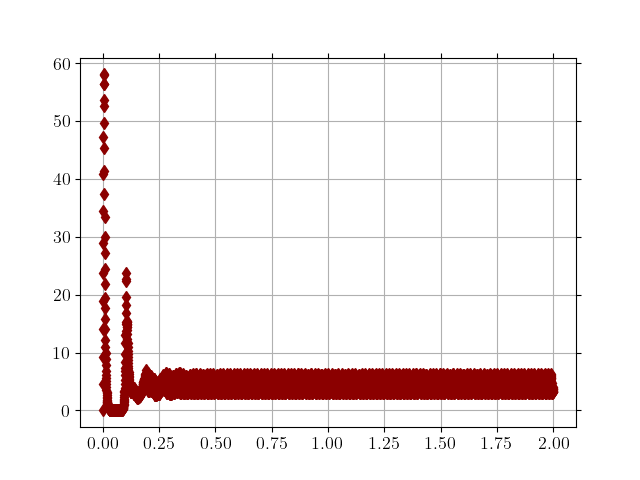

In [23]:
%matplotlib widget
indx = 10
indy = 7
time_scale, Id_interp, Va_interp = calc_curr(path + "data_cp_" + str(indx) + "_" + str(indy) + '/')

plt.figure()
plt.plot(time_scale*1e3, Id_interp, label="interpolated current", color="darkred", marker = "d", linestyle="")

In [24]:
## 2D map
lenx = 8
leny = 8
result_matrix = np.zeros((lenx, leny, 6))
for indx in range(1,lenx+1):
    for indy in range(1,leny+1):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'        
        result_matrix[indx-1, indy-1, :] = np.loadtxt(folder + "data_curr_BM_freq.txt", skiprows = 1)
#        print(indx,indy,result_matrix[indx-1, indy-1, 0])

In [62]:
def make_figure(results, title, xlabel, ylabel, vec, colobarlab):
    vmin=0
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=int(np.amax(results)+1)
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vec, vec, results, cmap='magma', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap

def make_figure_diff(results, title, xlabel, ylabel, vec, colobarlab):
    
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=int(np.amax(results)+1)
    vmin=-vmax
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vec, vec, results, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap



In [108]:
path_res = path + "data_cp_1_1/"
print(path_res)

ResultConfig = path_res +'Configuration.cfg'
configFile = ResultConfig
config = configparser.ConfigParser()
config.read(configFile)
physicalParameters = config['Physical Parameters']

test_multiple_alpha_B_SPT100/alpha_CP10/data_cp_1_1/


0.0097


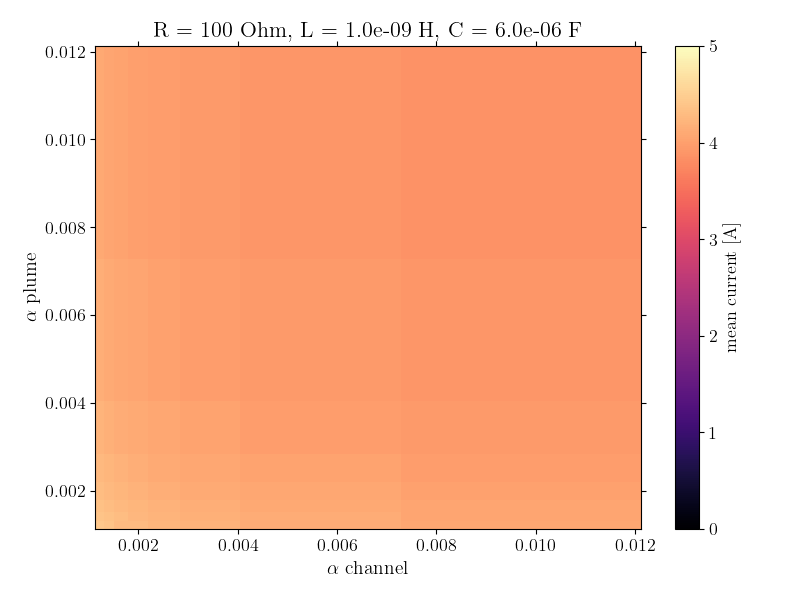

In [109]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start/np.arange(1,9)
results = result_matrix[:, :, 0]
colobarlab = "mean current [A]"

make_figure(results, title, xlabel, ylabel, vec, colobarlab)
plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


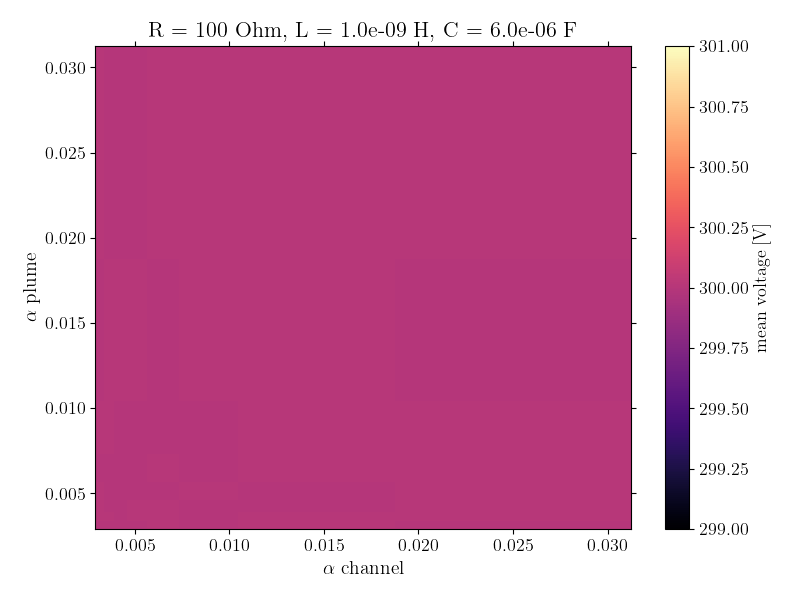

In [110]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
vec =  0.0250/np.arange(1,9)
results = result_matrix[:, :, 1]
colobarlab = "mean voltage [V]"

make_figure(results,  title, xlabel, ylabel, vec, colobarlab)

plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_volt_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


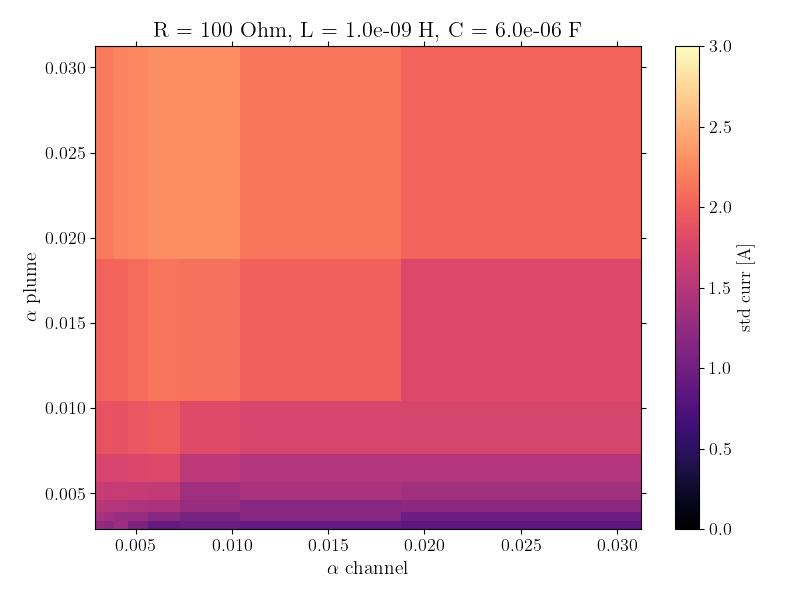

In [111]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
vec =  0.0250/np.arange(1,9)
results = result_matrix[:, :, 3]
colobarlab = "std curr [A]"

make_figure(results,  title, xlabel, ylabel, vec, colobarlab)

plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/std_curr_" 
            +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
            dpi=300, transparent=True, bbox_inches='tight')


0.0097


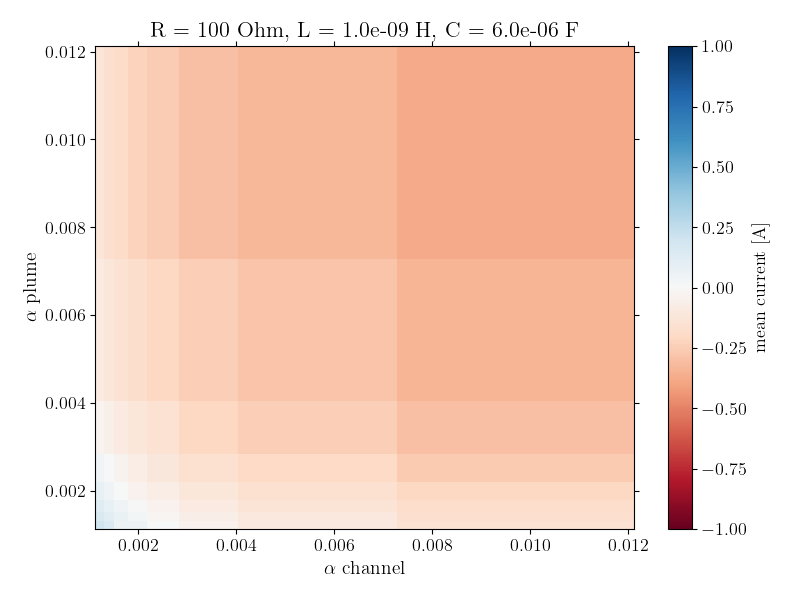

In [112]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ channel'
ylabel = r'$\alpha$ plume'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start/np.arange(1,9)
results = result_matrix[:, :, 0] - 4.23
colobarlab = "mean current [A]"

make_figure_diff(results, title, xlabel, ylabel, vec, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')


Text(0, 0.5, '$I_d - I_{SPT100}$')

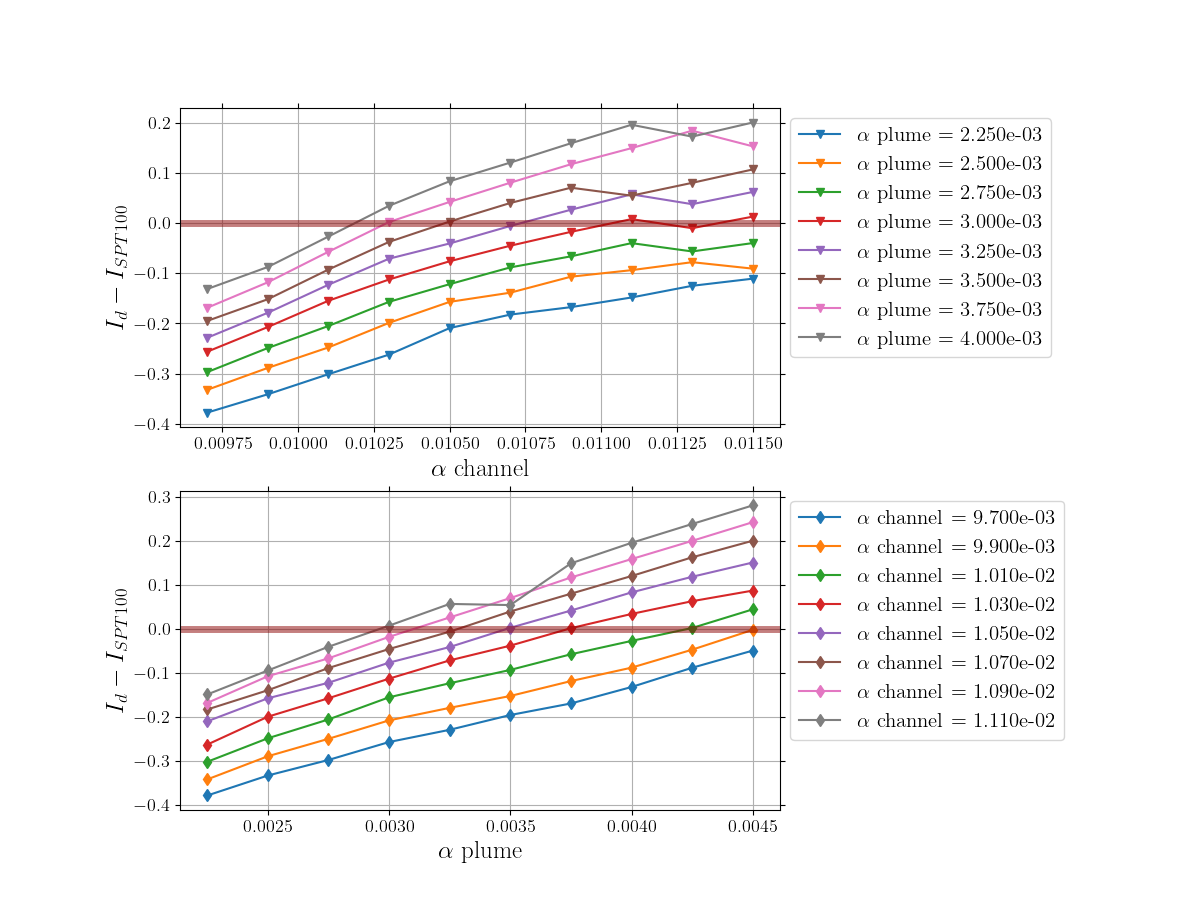

In [113]:
%matplotlib widget
plt.figure(figsize=(12.,9))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0.2, wspace=0.15, left=0.15, right=0.65, bottom=0.1)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])

for ind_a in range(len(results[:,0])):
    ax0.plot(alpha_B1, mean_curr_scaled[:,ind_a], marker="v", label = rf"$\alpha $ plume $ = $ {alpha_B2[ind_a]:.3e}")
    ax1.plot(alpha_B2, mean_curr_scaled[ind_a,:], marker="d", label = rf"$\alpha $ channel $ = $ {alpha_B1[ind_a]:.3e}")
    # ax0.axvline(vec[ind_a], linestyle = "--")
    # ax1.axvline(vec[ind_a], linestyle = "--")
ax0.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax1.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax0.axhline(y=0, alpha=.5, linewidth=5, color='darkred')
ax1.axhline(y=0, alpha=.5, linewidth=5, color='darkred')

ax0.set_xlabel(r'$\alpha$ channel', fontsize=18)
ax1.set_xlabel(r'$\alpha$ plume', fontsize=18)

ax0.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)
ax1.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)

# for bla in range(4):
#     if bla == 0:
#         CP4 = True
#     if bla == 1:
#         CP4 = False
#         CP5 = True
#     if bla == 2:
#         CP5 = False
#         CP6 = True
#     if bla == 3:
#         CP6 = False
#         CP7 = True
#     if CP4:
#         min_ch = 0.0089
#         # min_ch = 0.0074 + 0.0007625 * 1 - 0.0007625
#         max_ch = 0.0125
#         # max_ch = 0.0074 + 0.0007625 * 8 - 0.0007625
#         min_pl = 0.0051
#         # min_pl = 0.0045 + 0.0002187 * 1 - 0.0002187
#         max_pl = 0.00625
#         # max_pl = 0.0045 + 0.0002187 * 8 - 0.0002187
#         ax0.text(min_pl, 3, "CP4", fontsize=13, color=colors[bla])
#     elif CP5:
#         min_ch = 0.0046
#         max_ch = 0.0083
#         min_pl = 0.0068
#         max_pl = 0.0090
#         print("CP5")
#         ax0.text(min_pl, 2, "CP5", fontsize=13, color=colors[bla])
#     elif CP6:
#         min_ch = 0.0034
#         max_ch = 0.0043
#         min_pl = 0.0134
#         max_pl = 0.0440
#         print("CP6")
#         ax0.text(min_pl, 3, "CP6", fontsize=13, color=colors[bla])
#     elif CP7:
#         # min_ch = 0.0089
#         min_ch = 0.0074 + 0.0007625 * 1 - 0.0007625
#         # max_ch = 0.0125
#         max_ch = 0.0074 + 0.0007625 * 8 - 0.0007625
#         # min_pl = 0.0051
#         min_pl = 0.0045 + 0.0002187 * 1 - 0.0002187
#         max_pl = 0.00625
#         max_pl = 0.0045 + 0.0002187 * 8 - 0.0002187
#         print("CP4", min_ch, max_ch, min_pl, max_pl)
#         print((max_pl - min_pl)/8)
#         ax0.text(min_pl, 2, "CP7", fontsize=13, color=colors[bla])
#     ax0.axvspan(xmin=min_pl, xmax=max_pl, alpha=.5, color = colors[bla])
#     ax1.axvspan(xmin=min_ch, xmax=max_ch, alpha=.5, color = colors[bla])

# ax0.set_xscale('log')
# ax1.set_xscale('log')

# ax0.set_xticks(vec)
# ax1.set_xticks(vec)

# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/change_alpha_var.png",dpi=300, transparent=True, bbox_inches='tight')


## Graphs micro

In [114]:
def make_figure_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab):
    vmin=0
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=np.amax(results)
    vmin=(2*np.mean(results) - vmax)
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vecx, vecy, results, cmap='magma', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap

def make_figure_diff_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab):
    
    if int(np.amin(results)+1)>10:
        vmin = int(np.amin(results))
    vmax=np.amax(results)
    vmin=-vmax
    
    plt.figure(figsize=(8, 6))  # Set figure size
    
    # im = plt.imshow(result_matrix[:, :, 0], cmap='magma', vmin=vmin, vmax=vmax, origin='lower', interpolation='bilinear')  # Display the matrix, adjust colormap as needed
    im = plt.pcolor(vecx, vecy, results, cmap='RdBu', vmin=vmin, vmax=vmax)  # Display the matrix, adjust colormap as needed
    
    plt.title(title, fontsize=16)  # Add a title
    plt.xlabel(xlabel, fontsize=14)  # Add label for x-axis
    plt.ylabel(ylabel, fontsize=14)  # Add label for y-axis
    
    
    plt.colorbar(im, label=colobarlab)  # Add color bar with label
    
    plt.grid(False)  # Turn off grid lines
    
    plt.tight_layout()  # Adjust layout to prevent overlap



In [115]:
# path = "test_multiple_alpha_B_SPT100/alpha_CP/"
path = "test_multiple_alpha_B_SPT100/alpha_CP4/"
# path = "test_multiple_alpha_B_SPT100/alpha_CP5/"
path = "test_multiple_alpha_B_SPT100/alpha_CP6/"
# path = "test_multiple_alpha_B_SPT100/alpha_CP7/"
path = "test_multiple_alpha_B_SPT100/alpha_CP8/"

for indx in range(1,9):
    for indy in range(1,9):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'
        mean_current, mean_volta = make_fig_curr_FFT(path + 'figures/', folder, indx, indy, False)
    #    print(mean_current, mean_volta)
        plt.close()

a_ch = 9.00e-03, a_pl = 3.00e-03 mean curr = 3.91, ampl =  64.93


ValueError: too many values to unpack (expected 2)

In [ ]:
## 2D map
lenx = 8
leny = 8
result_matrix = np.zeros((lenx, leny, 4))
for indx in range(1,lenx+1):
    for indy in range(1,leny+1):
        folder = path + "data_cp_" + str(indx) + "_" + str(indy) + '/'        
        result_matrix[indx-1, indy-1, :] = np.loadtxt(folder + "data_curr_BM_freq.txt", skiprows = 1)
#        print(indx,indy,result_matrix[indx-1, indy-1, 0])

In [ ]:
try:
    vecx = np.loadtxt(path + 'vec_x.txt') 
    vecy = np.loadtxt(path + 'vec_y.txt')
    print("vecx and vecy loaded from: ", path)

    physicalParameters = config['Physical Parameters']
    vecx[indx-1] = float(physicalParameters['Anomalous transport alpha_B1'])
    physicalParameters = config['Physical Parameters']
    vecy[indy-1] = float(physicalParameters['Anomalous transport alpha_B2'])

except:
    vecx = np.zeros(8)
    vecy = np.zeros(8)
    for indx in range(1,9):
        path_res = path + f"data_cp_{indx}_1/"
        print(path_res)
        
        ResultConfig = path_res +'Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
        vecx[indx-1] = float(physicalParameters['Anomalous transport alpha_B1'])
        
    for indy in range(1,9):
        path_res = path + f"data_cp_1_{indy}/"
        print(path_res)
        
        ResultConfig = path_res +'Configuration.cfg'
        configFile = ResultConfig
        config = configparser.ConfigParser()
        config.read(configFile)
        physicalParameters = config['Physical Parameters']
        vecy[indy-1] = float(physicalParameters['Anomalous transport alpha_B2'])
    np.savetxt(path + 'vec_x.txt', vecx)
    np.savetxt(path + 'vec_y.txt', vecy)
print(vecx)
print(vecy)




In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ plume'
ylabel = r'$\alpha$ channel'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
results = result_matrix[:, :, 0]
colobarlab = "mean current [A]"

make_figure_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')

print(result_matrix[0, 0, 0])
print(result_matrix[-1, 0, 0])
print(result_matrix[0, -1, 0])
print(result_matrix[-1, -1, 0])


In [ ]:
title = f"R = {float(physicalParameters['R']):.0f} "+r"Ohm"+f", L = {float(physicalParameters['L']):.1e} H, C = {float(physicalParameters['C']):.1e} F"
xlabel = r'$\alpha$ plume'
ylabel = r'$\alpha$ channel'
alpha_start = float(physicalParameters['Anomalous transport alpha_B1'])
print(alpha_start)
vec =  alpha_start + np.arange(1,9)
results = result_matrix[:, :, 0] - 4.23
colobarlab = "mean current [A]"

make_figure_diff_zoom(results, title, xlabel, ylabel, vecx, vecy, colobarlab)
# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/mean_curr_" 
#             +f"R={float(physicalParameters['R']):.0f}"+r"Ohm"+f",L={float(physicalParameters['L']):.1e}H,C={float(physicalParameters['C']):.1e}F,Eps={float(physicalParameters['Crossover energy']):.1e}eV.png", 
#             dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
%matplotlib widget
plt.figure(figsize=(12.,9))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0.2, wspace=0.15, left=0.15, right=0.65, bottom=0.1)
ax0 = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])

for ind_a in range(len(results[:,0])):
    ax0.plot(vecx, results[:,ind_a], marker="v", label = rf"$\alpha $ plume $ = $ {vecy[ind_a]:.3e}")
    ax1.plot(vecy, results[ind_a,:], marker="d", label = rf"$\alpha $ channel $ = $ {vecx[ind_a]:.3e}")
ax0.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax1.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax0.axhline(y=0, alpha=.5, linewidth=5, color='darkred')
ax1.axhline(y=0, alpha=.5, linewidth=5, color='darkred')

ax0.set_xlabel(r'$\alpha$ channel', fontsize=18)
ax1.set_xlabel(r'$\alpha$ plume', fontsize=18)

ax0.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)
ax1.set_ylabel(r'$I_d - I_{SPT100}$', fontsize=18)

# ax0.set_xscale('log')
# ax1.set_xscale('log')

# plt.savefig("/home/petronio/LPP1D/test_multiple_alpha_B_SPT100/figures_comp/change_alpha_var.png",dpi=300, transparent=True, bbox_inches='tight')
